# Intro:
I use glucose sensor for **two** weeks to estimate my blood sugar level in near real time. In addition to glucose level I've also tracked all products I consumed. The purpose of the research is to investigate how different kind of products affect my glucose level. This notebook contains visualisation and some basic statistics using my glucose data.

# Findings:
I split findings on two groups: based on **things I noticed during the usage of the sensor** and **findings based on the data I've got** 
1) Things I noticed during the usage of the sensor:
   - Homemade desserts do not highly affect my glucose level.
   - I didn't notice effect of alcohol on glucose level. The sugar level even increased much slower after a glass of wine during diner.
   - Even low physical activities have positive effect on glucose level.
   - I didn't notice any significant effect of fruits on my glucose. However the biggest sugar peak appeared after I ate quite big and very sweet banana.
   - After significant increase of the glucose level your body try to compensate and your level can go very low. What means that you will be hungry again in quite short period of time. You should avoid such glucose "roller coaster".
2) Findings based on the data I've got:
   - In average I did 12 food related notes per day
   - In %50% of cases I take next portion in less than 1 hour (49 minutes).
   - In ~25% of cases I take next portion within 15 minutes.
   - In ~50% of cases sugar level increase to 6 and higher within ~ 20 minutes. Increase up to 8 took ~ 25 minutes
   - I found statistical significance on glucose increase only for sweet products. Carbs quite on the edge. What can be related to the fact that I usually consume "healthy" version of carbs, e.g. home made dessert with low sugar level.
   -

# Next Steps:

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from src.etl import SugarData
import pathlib
import re
import statsmodels.formula.api as smf

from scipy.stats import linregress


init_notebook_mode(connected=True)

local_path = pathlib.Path().resolve()

GREY = "#a3a3a3"

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 30)

# Inro 
The purpose of the notebook to have a first look into the data 

# Read data

In [3]:
data = SugarData(local_path / "data" / "IvanUstyuzhaninov_glucose_12-6-2021.csv")

INFO:root: __read_data [DONE], Resulting Data Shape=(1732, 19)
INFO:root: __clean_data [DONE], Resulting Data Shape=(1597, 3)
INFO:root: __glucose [DONE], Resulting Data Shape=(1440, 2)
INFO:root: __notes [DONE], Resulting Data Shape=(157, 14)
INFO:root: __glucose_resampled [DONE], Resulting Data Shape=(20066, 2)


In [4]:
print(f"Start Date: {data.cleaned['datetime'].min()}")
print(f"End Date: {data.cleaned['datetime'].max()}")

Start Date: 2021-05-21 01:58:00
End Date: 2021-06-04 00:23:00


In [5]:
print("Glucose Level Basic Stats:")
glucose_stats = data.glucose[["glucose_level"]].describe().T
display(glucose_stats)

Glucose Level Basic Stats:


,count,mean,std,min,25%,50%,75%,max
glucose_level,1440.0,4.801405,0.885642,2.664,4.1625,4.7175,5.328,9.9345


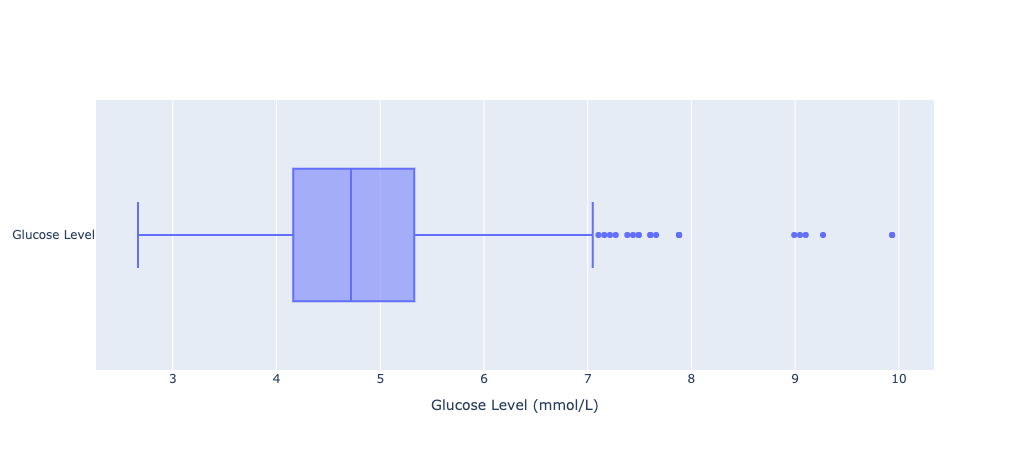

In [6]:
box = go.Box(x=data.glucose["glucose_level"], name="Glucose Level")
layout = go.Layout(xaxis=dict(title="Glucose Level (mmol/L)"))
go.Figure(data=[box], layout=layout)

In [7]:
print("Notes Basic Stats:")
print(f"Total Number of Notes: {len(data.notes)}")

Notes Basic Stats:
Total Number of Notes: 157


# Show Raw Measurements in time

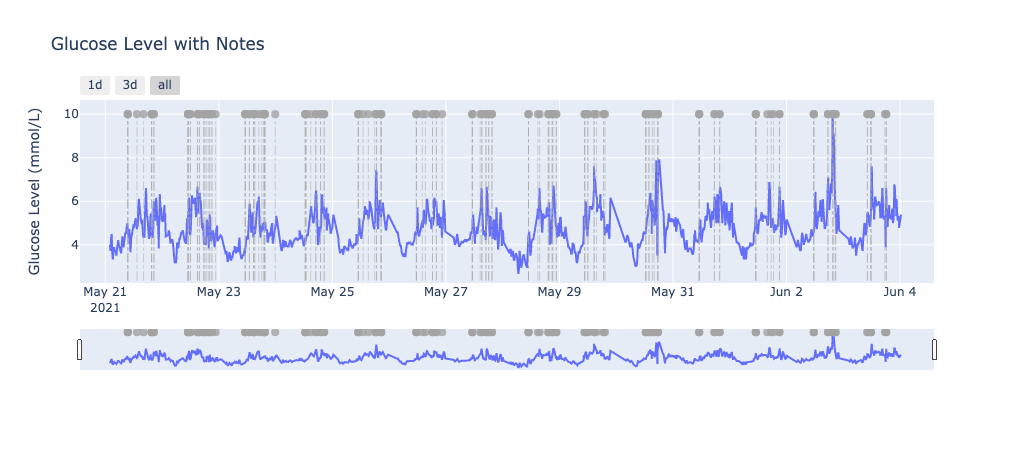

In [8]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data.glucose["datetime"],
        y=data.glucose["glucose_level"],
        name="Glucose Level",
    )
)


# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=3, label="3d", step="day", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)
fig.update_layout(
    title="Glucose Level with Notes",
    showlegend=False,
    yaxis=dict(title="Glucose Level (mmol/L)"),
)

# Add notes points
for n in data.notes.index:
    x = data.notes.loc[n, "datetime"]
    y = 10

    fig.add_shape(
        type="line",
        x0=x,
        y0=data.glucose.glucose_level.min() - 0.3,
        x1=x,
        y1=y,
        line=dict(
            color=GREY,
            width=0.5,
            dash="dashdot",
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=[x],
            y=[10],
            text=[data.notes.loc[n, "notes"]],
            marker=dict(size=8, opacity=0.8, color=GREY),
        )
    )


fig.show()

- The highest glucose level was **10.4** after Banana; salad; turkey and potato. Value looks a bit too high.
- We have a lot of different kind of products and quite limited number of total notes. For simplicity we can split them on different groups

In [11]:
data.notes[lambda d: d["feelings"] == 1]

,datetime,notes,notes_norm,activities,feelings,fruits,hot_drinks,salad,vegetables,fat,sweet,protein,carbs,alcohol


# Basic Analysis
Plan:
1. Calculate average intervals between food consumtion. **Findings**:
   - In %50% of cases I take next portion in less than 1 hour (49 minutes).
   - In ~25% of cases I take next portion within 15 minutes.
2. Calculate how fast sugar level increases to 6 or higher after consumtion if level is already higher than 6 or goes below we ignore such cases. 
   **Findings:**
   - In ~50% of cases sugar level increase to 6 and higher within ~ 20 minutes. Increase up to 8 took ~ 25 minutes

## 1. Average intervals between food consumption

In [12]:
notes_datetime = (
    data.notes.sort_values(by="datetime")
    .loc[:, ["datetime"]]
    .assign(
        minutes_from_previous_food=lambda d: (
            d["datetime"] - d["datetime"].shift(1)
        ).dt.seconds
        / 60
    )
)
notes_datetime[["minutes_from_previous_food"]].describe(
    percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
minutes_from_previous_food,156.0,123.339744,238.113811,0.0,0.0,0.0,0.0,30.5,112.25,323.0,820.25,1044.0


## 2. Calculate how fast sugar level increases

In [13]:
glucose_with_notes = (
    pd.merge(data.glucose_resampled, data.notes, how="outer", on="datetime")
    .sort_values(by="datetime")
    .reset_index(drop=True)
)


def get_minutes_to_high_sugar(check_up_to_minutes: int, level_of_interest: int) -> None:
    minutes_to_high_sugar = []
    for i in glucose_with_notes.loc[glucose_with_notes["notes"].notnull()].index:
        if glucose_with_notes.loc[i, "glucose_level"] > level_of_interest:
            continue
        period_of_interest = glucose_with_notes.loc[i : i + check_up_to_minutes]

        index_with_high_level = period_of_interest.loc[
            lambda d: d["glucose_level"] > level_of_interest
        ].index

        # use first if available
        if len(index_with_high_level) > 0:
            minutes_to_high_sugar.append(index_with_high_level[0] - i)
    print("_______________")
    print(
        f"Check how fast sugar level increase within {check_up_to_minutes} minutes up to {level_of_interest}"
    )
    display(
        pd.DataFrame({"minutes_to_high_sugar": minutes_to_high_sugar})
        .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
        .T
    )
    return


get_minutes_to_high_sugar(check_up_to_minutes=30, level_of_interest=6)
get_minutes_to_high_sugar(check_up_to_minutes=60, level_of_interest=6)
get_minutes_to_high_sugar(check_up_to_minutes=120, level_of_interest=6)
get_minutes_to_high_sugar(check_up_to_minutes=30, level_of_interest=8)
get_minutes_to_high_sugar(check_up_to_minutes=60, level_of_interest=8)
get_minutes_to_high_sugar(check_up_to_minutes=120, level_of_interest=8)

_______________
Check how fast sugar level increase within 30 minutes up to 6


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,18.0,17.0,7.02935,1.0,15.25,19.5,22.75,23.3,24.0,24.0


_______________
Check how fast sugar level increase within 60 minutes up to 6


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,35.0,27.942857,13.281883,1.0,19.5,24.0,38.0,40.6,49.1,55.0


_______________
Check how fast sugar level increase within 120 minutes up to 6


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,49.0,50.326531,37.739451,1.0,22.0,37.0,96.0,113.2,114.6,119.0


_______________
Check how fast sugar level increase within 30 minutes up to 8


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_______________
Check how fast sugar level increase within 60 minutes up to 8


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_______________
Check how fast sugar level increase within 120 minutes up to 8


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,2.0,113.5,0.707107,113.0,113.25,113.5,113.75,113.9,113.95,114.0


In [14]:
glucose_with_notes[:5]

,datetime,glucose_level,notes,notes_norm,activities,feelings,fruits,hot_drinks,salad,vegetables,fat,sweet,protein,carbs,alcohol
0,2021-05-21 01:58:00,3.9960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-21 01:59:00,3.9775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-05-21 02:00:00,3.9590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-05-21 02:01:00,3.9405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-05-21 02:02:00,3.9220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##  3. Appendix: Show products mapping

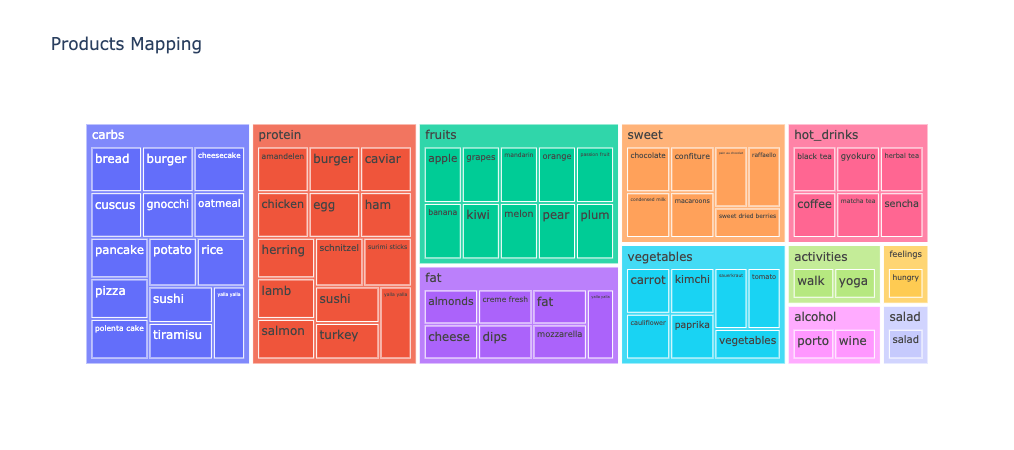

In [15]:
import plotly.express as px


# read gin file as string to extract mapping
with open("src/config.gin", "r") as file:
    mapping = file.read().replace("\n", "")
mapping = eval(mapping.split("=")[1])

mapping_df = [0] * len(mapping)
i = 0
for key, item in mapping.items():
    mapping_df[i] = pd.DataFrame({"Group": [key] * len(item), "Products": item})
    i += 1
mapping_df = pd.concat(mapping_df, sort=False, ignore_index=True)

fig = px.treemap(mapping_df, path=["Group", "Products"], title="Products Mapping")
fig.show()

## 4. Average # portions per day

In [14]:
notes_food = data.notes.loc[
    lambda d: (d["activities"] == 0) & (d["feelings"] == 0)
].assign(date=lambda d: d["datetime"].dt.date)

notes_grouped_by_day = notes_food[["date", "notes"]].groupby("date").count()
display(notes_grouped_by_day)
print(f"Average notes per day: {notes_grouped_by_day.sum()/len(notes_grouped_by_day)}")

,notes
date,
2021-01-29,11
2021-01-30,11
2021-01-31,10
2021-02-01,17
2021-02-02,15
2021-02-03,13
2021-02-04,11
2021-02-05,13
2021-02-06,11


Average notes per day: notes    12.214286
dtype: float64


# Estimate Food Effect
**Plan:**
1. Try to calculate slope difference before food consumption and right after it within 20 min. If we we take the new portion within 20 min then we consider this period for slope calculation. **Findings:**
   - Top products by glucose increase do not make a lot of sense what can be related to the previous products consumed. The approach must be reconsidered
2. Check moment when glucose level increased up to 6, 7 or 8 and see what food was consumed -N- minutes before that. **Findings:**
   - An amount of data is quite limited, so it's hard to make final conclusions at that moment. 
   - Statistically significant effect on the sugar level increase was find only for Sweet products. Carbs affected the sugar level only when I used glucose_level_of_interest = 5.8. 

## 1. Slope change comparison

In [15]:
minutes_range = 20

# remove feelings
glucose_with_notes = (
    glucose_with_notes.loc[lambda d: d["feelings"] != 1]
    .drop("feelings", axis=1)
    .reset_index(drop=True)
)

notes_glucose_slope = glucose_with_notes.loc[lambda d: d["notes"].notnull()].copy()


def slope(X: pd.Series) -> pd.Series:
    X_slope = linregress([i for i in range(len(X))], X)[0]
    if np.isnan(X_slope):
        return 0.0
    return X_slope


notes_index = notes_glucose_slope.index
notes_glucose_slope["slope_diff"] = float("NaN")
for i in range(len(notes_index)):
    index_note = notes_index[i]  # index of the note for which we do prediction

    # select closest previous note or current note - 20 minutes
    if i != 0:
        index_start = max(notes_index[i - 1], index_note - minutes_range)
    else:
        index_start = index_note - minutes_range

    # select closest next note or current note + 20 minutes
    if i != len(notes_index) - 1:
        index_end = min(notes_index[i + 1], index_note + minutes_range)
    else:
        index_end = index_note + minutes_range

    slope_before = slope(
        glucose_with_notes.loc[index_start:index_note, "glucose_level"]
    )
    slope_after = slope(glucose_with_notes.loc[index_note:index_end, "glucose_level"])

    notes_glucose_slope.loc[index_note, "slope_diff"] = slope_after - slope_before

print("Top 10 Notes by slope increase:")
notes_glucose_slope.sort_values(by="slope_diff", ascending=False)[:10]

/Users/artem/workmaterials/various/sugar-level/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning:

invalid value encountered in sqrt



Top 10 Notes by slope increase:


,datetime,glucose_level,notes,notes_norm,activities,fruits,hot_drinks,salad,vegetables,fat,sweet,protein,carbs,alcohol,slope_diff
3047,2021-01-31 12:30:00,5.120000,Coffee small cup,coffee small cup,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.175725
5950,2021-02-02 12:52:00,5.708333,Gyokuro,gyokuro,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151977
1981,2021-01-30 18:44:00,4.933333,Grapes,grapes,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145043
6254,2021-02-02 17:55:00,5.900000,chocolate,chocolate,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.140990
5713,2021-02-02 08:55:00,5.100000,1 pancake with creme fresh and framboise confi...,1 pancake with creme fresh and framboise confi...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.134308
4471,2021-02-01 12:14:00,5.655556,Banana,banana,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125119
14354,2021-02-08 08:56:00,4.600000,Coffee,coffee,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117889
8585,2021-02-04 08:46:00,5.250000,Banana 1/2,banana 1/2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112042
14427,2021-02-08 10:09:00,4.300000,Measurements look weird,measurements look weird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109362
5879,2021-02-02 11:41:00,5.710000,Mandarin,mandarin,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103130


## 2. Check all consumed products before glucose increase
We check when glucose level increased up to **glucose_level_of_interest** and what we ate **minutes_of_interest** before that

In [16]:
def consumed_products_before_glucose_increase(
    glucose_level_of_interest: int, minutes_of_interest: int
) -> pd.DataFrame:
    return (
        glucose_with_notes.assign(
            # we do fillna with average glucose for first two notes before measurements started
            glucose_level=lambda d: d["glucose_level"].fillna(5.5)
        )
        # fillna the rest with -0-
        .fillna(0)
        .assign(
            abnormal_glucose_level=lambda d: np.where(
                d["glucose_level"] < glucose_level_of_interest, 0, 1
            ),
            was_previous_level_abnormal=lambda d: d["abnormal_glucose_level"].shift(1),
            glucose_switched_to_abnormal=lambda d: np.where(
                (d["abnormal_glucose_level"] == 1)
                & (d["was_previous_level_abnormal"] == 0),
                1,
                0,
            ),
            time_when_next_switch_happened=lambda d: np.where(
                d["glucose_switched_to_abnormal"] == 1,
                d["datetime"].astype(str),
                pd.NaT,
            ),
            glucose_when_next_switch_happened=lambda d: np.where(
                d["glucose_switched_to_abnormal"] == 1, d["glucose_level"], float("NaN")
            ),
        )
        .fillna(method="bfill")
        .assign(
            minutes_until_switch=lambda d: (
                d["time_when_next_switch_happened"] - d["datetime"]
            ).dt.seconds
            / 60
        )
        .loc[
            lambda d: d["minutes_until_switch"] <= minutes_of_interest,
            [
                #                 "activities",
                "fruits",
                "hot_drinks",
                "salad",
                "vegetables",
                "fat",
                "sweet",
                "protein",
                "carbs",
                "alcohol",
                "time_when_next_switch_happened",
                "glucose_when_next_switch_happened",
            ],
        ]
        .groupby(
            ["time_when_next_switch_happened", "glucose_when_next_switch_happened"]
        )
        .sum()
        .reset_index()
    )


abt = consumed_products_before_glucose_increase(
    glucose_level_of_interest=6, minutes_of_interest=60
)

In [17]:
# fit OLS

import statsmodels.formula.api as smf


def calculate_ols(glucose_level_of_interest: int, minutes_of_interest: int) -> None:
    abt = consumed_products_before_glucose_increase(
        glucose_level_of_interest, minutes_of_interest
    )
    results = smf.ols(
        "glucose_when_next_switch_happened ~ fruits+hot_drinks+salad+vegetables+fat+sweet+protein+carbs+alcohol",
        data=abt,
    ).fit()
    display(results.summary())


calculate_ols(glucose_level_of_interest=6, minutes_of_interest=60)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     glucose_when_next_switch_happened   R-squared:                       0.153
Model:                                           OLS   Adj. R-squared:                  0.074
Method:                                Least Squares   F-statistic:                     1.933
Date:                               Wed, 07 Apr 2021   Prob (F-statistic):             0.0561
Time:                                       13:05:42   Log-Likelihood:                -3.8594
No. Observations:                                106   AIC:                             27.72
Df Residuals:                                     96   BIC:                             54.35
Df Model:                                          9                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0180      0.036    167.047      0.000       5.947       6.090
fruits        -0.0162      0.044     -0.366      0.715      -0.104       0.072
hot_drinks     0.0550      0.064      0.856      0.394      -0.072       0.182
salad         -0.0897      0.165     -0.544      0.587      -0.417       0.238
vegetables     0.0341      0.091      0.373      0.710      -0.147       0.216
fat           -0.0690      0.087     -0.797      0.427      -0.241       0.103
sweet          0.2586      0.086      3.005      0.003       0.088       0.429
protein       -0.0100      0.084     -0.119      0.905      -0.176       0.156
carbs          0.0728      0.068      1.065      0.290      -0.063       0.208
alcohol        0.0366      0.084      0.435      0.664      -0.130       0.204
==============================================================================
Omnibus:                      188.067   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18621.115
Skew:                           7.124   Prob(JB):                         0.00
Kurtosis:                      66.349   Cond. No.                         8.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
calculate_ols(glucose_level_of_interest=5.8, minutes_of_interest=60)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     glucose_when_next_switch_happened   R-squared:                       0.155
Model:                                           OLS   Adj. R-squared:                  0.089
Method:                                Least Squares   F-statistic:                     2.364
Date:                               Wed, 07 Apr 2021   Prob (F-statistic):             0.0172
Time:                                       13:05:42   Log-Likelihood:                -5.2864
No. Observations:                                126   AIC:                             30.57
Df Residuals:                                    116   BIC:                             58.94
Df Model:                                          9                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8139      0.032    179.719      0.000       5.750       5.878
fruits        -0.0160      0.047     -0.336      0.737      -0.110       0.078
hot_drinks     0.0225      0.069      0.328      0.744      -0.113       0.158
salad         -0.1242      0.145     -0.856      0.394      -0.411       0.163
vegetables    -0.0014      0.077     -0.019      0.985      -0.153       0.150
fat           -0.0666      0.072     -0.920      0.359      -0.210       0.077
sweet          0.2897      0.087      3.321      0.001       0.117       0.462
protein        0.0020      0.078      0.025      0.980      -0.153       0.157
carbs          0.1169      0.064      1.825      0.071      -0.010       0.244
alcohol       -0.0211      0.088     -0.240      0.811      -0.196       0.154
==============================================================================
Omnibus:                      217.235   Durbin-Watson:                   1.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26002.978
Skew:                           7.302   Prob(JB):                         0.00
Kurtosis:                      71.845   Cond. No.                         7.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
calculate_ols(glucose_level_of_interest=7, minutes_of_interest=60)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     glucose_when_next_switch_happened   R-squared:                       0.224
Model:                                           OLS   Adj. R-squared:                  0.012
Method:                                Least Squares   F-statistic:                     1.057
Date:                               Wed, 07 Apr 2021   Prob (F-statistic):              0.419
Time:                                       13:05:42   Log-Likelihood:                 1.9001
No. Observations:                                 43   AIC:                             16.20
Df Residuals:                                     33   BIC:                             33.81
Df Model:                                          9                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0466      0.071     98.994      0.000       6.902       7.191
fruits        -0.0172      0.065     -0.264      0.793      -0.149       0.115
hot_drinks     0.0400      0.099      0.405      0.688      -0.161       0.241
salad         -0.0617      0.301     -0.205      0.839      -0.673       0.550
vegetables    -0.1145      0.110     -1.045      0.304      -0.337       0.108
fat            0.0121      0.129      0.094      0.926      -0.251       0.275
sweet          0.2315      0.113      2.047      0.049       0.001       0.462
protein       -0.0240      0.124     -0.195      0.847      -0.275       0.227
carbs          0.0563      0.105      0.535      0.596      -0.158       0.270
alcohol       -0.0412      0.104     -0.396      0.695      -0.253       0.171
==============================================================================
Omnibus:                       73.653   Durbin-Watson:                   1.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1011.220
Skew:                           4.217   Prob(JB):                    2.61e-220
Kurtosis:                      25.210   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""